In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pytrends.request import TrendReq

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# GDP data reading and cleaning

In [3]:
gdp_path = '../../data/expenditure/expenditure_gdp.csv'
gdp = pd.read_csv(gdp_path)
gdp['REF_DATE'] = pd.to_datetime(gdp['REF_DATE'])
gdp.head(2)

C:\Users\sidhu\AppData\Local\Temp/ipykernel_21128/2999133702.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gdp = pd.read_csv(gdp_path)


,REF_DATE,GEO,DGUID,Prices,Seasonal adjustment,Estimates,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Final consumption expenditure,Dollars,81,millions,6,v62305723,1.1.1.1,273818.0,NaN,NaN,NaN,0
1,1961-01-01,Canada,2016A000011124,Chained (2012) dollars,Seasonally adjusted at annual rates,Household final consumption expenditure,Dollars,81,millions,6,v62305724,1.1.1.2,182300.0,NaN,NaN,NaN,0


### Extracted only required columns and rows

In [4]:
# filter data
gdp_subset = gdp[(gdp['REF_DATE'] >= '2004-01-01') &
                (gdp['Prices'] == 'Chained (2012) dollars') & 
                (gdp['Estimates'] == 'Gross domestic product at market prices') &
                 (gdp['UOM'] == 'Dollars')]
gdpts = gdp_subset[['REF_DATE', 'VALUE']]

# rename columns
gdpts = gdpts.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'GDP'})
gdpts.index = gdpts['Date']
gdpts = gdpts.drop(columns = ['Date'])

In [5]:
gdpts.head()

,GDP
Date,
2004-01-01,1566737.0
2004-04-01,1585347.0
2004-07-01,1604061.0
2004-10-01,1615585.0
2005-01-01,1621176.0


### Time series of GDP

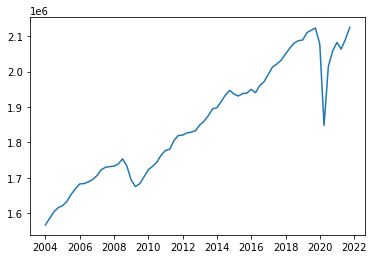

In [6]:
gdp_data = gdpts.copy()
plt.plot(gdp_data['GDP'])
plt.show()

### Growth rate of GDP

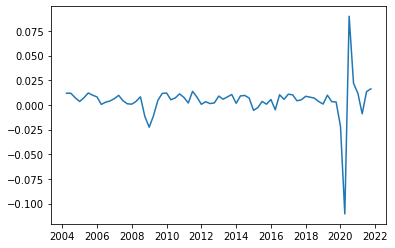

In [7]:
gdpts['GDP_GrowthRate'] = gdpts['GDP'].pct_change()
gdpts = gdpts.dropna()

plt.plot(gdpts['GDP_GrowthRate'])
plt.show()

### Check stationarity

In [8]:
# source link: https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

In [9]:
adf_test(gdpts['GDP_GrowthRate'])


Series is stationary


In [10]:
kstest = kpss_test(gdpts['GDP_GrowthRate'])

Series is stationary


C:\Users\sidhu\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Get predictors from Google Trends

In [9]:
# get caegories and keywords from csv file
key_path = '../../data/keywords_data/GDP.csv'
key_data = pd.read_csv(key_path)
cat_lst = key_data['CatNo'].unique()                    # list of categories
keywords_lst = key_data['Keywords'].dropna()   # list of selected keywords
keyCat_lst = key_data['keywordCatNo'].astype('Int64').dropna()   # list of categories corresponding to keywords

#### function to get trends using keyword/category

In [109]:
pytrends = TrendReq(hl='en-US', backoff_factor=0.1)

# function to get google trend time series of respective


def get_trends(keyword=[''], category='0', related_queries=0, related_topics=0):
    """ function to get the google trend for desired keyword and category"""
    kw_list = keyword
    cat = category
    timeframe = '2004-01-01 2022-04-01'
    geo = 'CA'
    gprop = ''

    try:
        pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
        # get time series
        data = pytrends.interest_over_time()
    except:
        print(f"Category {cat} does not exist or keyword {kw_list[0]} has no time series")
        return [''], [''], ['']

    # get related queries
    try:
        if related_queries > 0:
            queries = pytrends.related_queries()
            if len(kw_list) == 0:
                queries_lst = list(queries['']['top']['query'].values[0:related_queries])
            else:
                queries_lst = list(queries[kw_list[0]]['top']['query'].values[0:related_queries])
        else:
            queries_lst = ['']
    except:
        queries_lst = ['']

    # get related topics
    try:
        if related_topics > 0:
            topics = pytrends.related_topics()
            if len(kw_list) == 0:
                topics_lst = list(topics['']['top']['topic_title'].values[0:related_topics])
            else:
                topics_lst = list(topics[kw_list[0]]['top']['topic_title'].values[0:related_topics])
        else:
            topics_lst = ['']
    except:
        topics_lst = ['']
    return data, queries_lst, topics_lst

#### function to get trends using keyword and respective category from a dictionary

In [68]:
# get timeseries dataframe of related queries and topics (top 2) of different selected categories
def get_trends_for_dict(dict):
    i = 0
    for key, value in dict.items():
        category = key
        kw_lst = set(value)  # removes the repeated keywords
        for keyword in kw_lst:
            data, _, _ = get_trends(keyword=[keyword], category=category)

            # Code to append data for different keywords in data frame
            colname = category+"_"+keyword
            if len(data) == 0:
                continue
            else:
                if i == 0:
                    data.rename(columns={keyword: colname}, inplace=True)
                    df = data.drop(columns=['isPartial'])
                else:
                    data.rename(columns={keyword: colname}, inplace=True)
                    data = data.drop(columns=['isPartial'])
                    df = df.join(data)
            i = i+1
    return df

In [14]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

# get time series and related queries and topics of categories
for i, category in enumerate(cat_lst):
    category = str(category)
    data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
    cat_queries_dict[category] = queries
    cat_topics_dict[category] = topics

    # Code to append data for different columns in data frame
    if i == 0:
        data.rename(columns={'': category}, inplace=True)
        categoryts = data.drop(columns=['isPartial'])
    else:
        data.rename(columns={'': category}, inplace=True)
        data = data.drop(columns=['isPartial'])
        categoryts = categoryts.join(data)

In [110]:
# get dataframe of timeseries for keywords

keywords_queries_dict = {}
keywords_topics_dict = {}

# get time series and related queries and topics of selected keywords
for i, keyword in enumerate(keywords_lst):
    category = str(keyCat_lst[i])
    data, queries, topics = get_trends(keyword=[keyword], category=category, related_queries=2, related_topics=2)
    keywords_queries_dict[category] = queries
    keywords_topics_dict[category] = topics
    

    # Code to append data for different columns in data frame
    if i == 0:
        keywordsts = data.drop(columns=['isPartial'])
    else:
        data = data.drop(columns=['isPartial'])
        keywordsts = keywordsts.join(data)

In [114]:
# Read data from dictionaries
file1 = open('gdp_cat_queries_dict.json')
keywords_queries_dict = json.load(file1)

In [126]:
#keywords_queries_dict

In [117]:
df1 = get_trends_for_dict(cat_queries_dict)
df1

Category 794 does not exist or keyword gps has no time series


AttributeError: 'list' object has no attribute 'rename'

### Store data

In [534]:
keywordsts.to_csv('gdp_keywords_ts.csv')
categoryts.to_csv('gdp_category_ts.csv')

#store Queries and topics
with open('gdp_cat_queries_dict.json', 'w') as fp:
    json.dump(cat_queries_dict, fp,  indent=4)

with open('gdp_cat_topics_dict.json', 'w') as fp:
    json.dump(cat_topics_dict, fp,  indent=4)
    
with open('gdp_keywords_queries_dict.json', 'w') as fp:
    json.dump(keywords_queries_dict, fp,  indent=4)

with open('gdp_keywords_topics_dict.json', 'w') as fp:
    json.dump(keywords_topics_dict, fp,  indent=4)

In [18]:
keywordsts.to_csv('gdp_keywords_ts_1205.csv')
categoryts.to_csv('gdp_category_ts_1205.csv')

### Read data

In [118]:
keywordsts = pd.read_csv('gdp_keywords_ts.csv', index_col=0)
categoryts = pd.read_csv('gdp_category_ts.csv', index_col=0)

# data on 12-05-2022
categoryts_today = pd.read_csv('gdp_category_ts_1205.csv', index_col=0)

### Check for two samples at different time

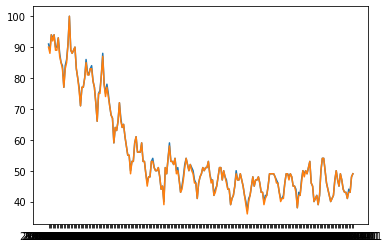

In [119]:
temp = pd.DataFrame({'A':categoryts[categoryts.columns[2:3]]['47'], 'B':categoryts_today[categoryts_today.columns[2:3]]['47']})
plt.plot(temp[temp.columns[0:5]])
plt.show()

# Remove long-term bias (downward trend)

### Functions to extract long term trend and remove long term bias

In [48]:
# function to get long term trend
# source link: statsmodels.org/dev/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html

def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(dataframe)
    log_category = np.log(dataframe)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values

    return transformed_data

In [49]:
transformed_data = remove_downward_trend_bias(categoryts)

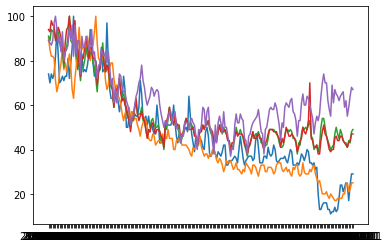

In [50]:
plt.plot(categoryts[categoryts.columns[0:5]])
plt.show()

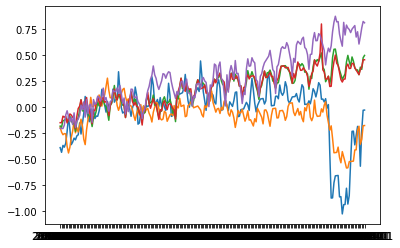

In [51]:
plt.plot(transformed_data[transformed_data.columns[0:5]])
plt.show()

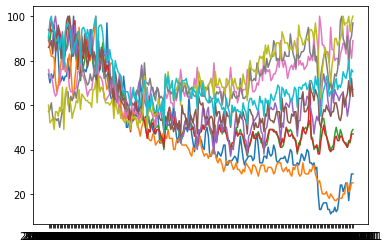

In [124]:
plt.plot(categoryts[categoryts.columns[0:10]])
plt.show()

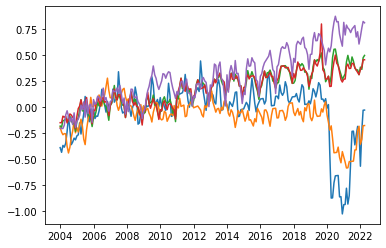

In [549]:
plt.plot(transformed_data[transformed_data.columns[0:5]])
plt.show()

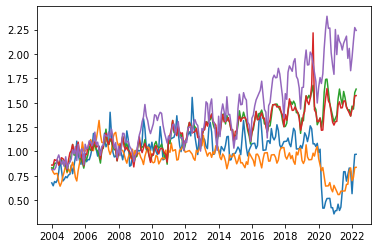

In [551]:
plt.plot(np.exp(new[new.columns[0:5]]))
plt.show()

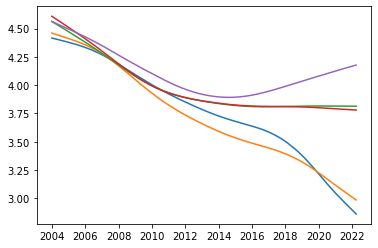

In [420]:
plt.plot(longtrend_data[longtrend_data.columns[0:5]])
plt.show()

In [553]:
# Normalize data
scaler = StandardScaler()
scaler.fit(new)
scaled_df = pd.DataFrame(scaler.transform(new))


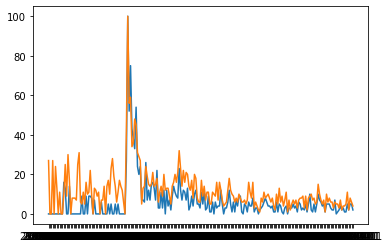

In [55]:
plt.plot(keywordsts[keywordsts.columns[0:2]])
plt.show()

# Make GDP data quarterly

In [171]:
keywordsts.index = pd.to_datetime(keywordsts.index)

list(gdpts.index.month.unique())

[4, 7, 10, 1]

In [178]:
list(keywordsts.index.month.values) in list(gdpts.index.month.unique())

False

In [180]:
gdpts.head()

,GDP,GDP_GrowthRate
Date,,
2004-04-01,1585347.0,0.011878
2004-07-01,1604061.0,0.011804
2004-10-01,1615585.0,0.007184
2005-01-01,1621176.0,0.003461
2005-04-01,1632938.0,0.007255


In [179]:
keywordsts

,Economic crisis,Crisis,Recession,Financial crisis,Krach,Unemployment,Unemployment benefits,Student loan,Loan,Interest,...,Temporary jobs,Affordable housing,Lawyer,public debt,office space,Housing bubble,Bankruptcy,Exportation,Commercial Building,Foreclosure
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,27,0,0,0,27,25,43,55,44,...,0,0,30,37,92,0,39,58,100,42
2004-02-01,0,0,0,0,36,23,5,53,46,46,...,39,0,31,0,97,13,52,100,71,31
2004-03-01,0,0,0,0,44,20,32,34,42,45,...,71,0,45,51,78,16,38,58,38,43
2004-04-01,0,27,50,100,0,22,10,43,55,56,...,38,0,32,41,67,0,47,87,40,23
2004-05-01,0,0,45,0,0,17,14,41,50,49,...,0,0,35,0,53,17,40,66,9,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01,5,11,5,11,19,10,7,47,68,48,...,14,21,69,35,35,19,16,16,45,17
2022-01-01,2,2,16,5,29,11,10,47,73,71,...,20,12,78,22,49,26,16,12,61,22
2022-02-01,5,8,9,12,14,7,4,44,77,68,...,19,76,83,20,47,23,16,14,60,22


# Make series stationary

In [128]:
# function to normalize data



### Plot trends

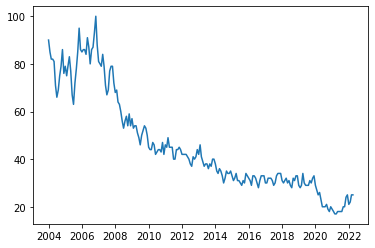

In [231]:
trend_data = categoryts.copy()
plt.plot(trend_data['23'])
plt.show()

In [12]:
pytrends.suggestions("Economic crisis")

[{'mid': '/g/1211cg58', 'title': 'economic crisis', 'type': 'Topic'},
 {'mid': '/g/11q2xlm4ss',
  'title': '2019–present Sri Lankan economic crisis',
  'type': 'Event'},
 {'mid': '/m/080pqzt',
  'title': '1998–1999 Ecuador economic crisis',
  'type': 'Topic'},
 {'mid': '/g/11bwdr23n9',
  'title': '2013–present economic crisis in Venezuela',
  'type': 'Topic'},
 {'mid': '/m/05p85kd',
  'title': '1991 Indian economic crisis',
  'type': 'Topic'}]